# Сборный проект 2. Анализ пользовательского поведения в мобильном приложении

Цель проекта: на основе данных использования мобильного приложения для продажи продуктов питания проанализировать воронку продаж, а также оценить результаты A/A/B-тестирования 

План работы:
1. Подключить необходимые библиотеки для работы
2. Изучить общую информацию о наборе данных:
* загрузить файлы
* посмотреть количество данных, их тип, пропущенные значения, дубликаты, название столбцов
* сделать вывод
3. Провести предварительную обработку данных:
* переименовать столбцы в соответствии с правилами
* изменить тип данных
* обработать дубликаты
* создать новые столбцы
* сделать вывод
4. Провести исследовательский анализ данных:
* сколько всего событий в логе?
* сколько всего пользователей в логе?
* сколько в среднем событий приходится на пользователя?
* определить временной период с полными данными
* много ли событий и пользователей вы потеряли, отбросив старые данные?
* проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.
* сделать вывод
5. Изучить воронку событий:
* посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
* посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
* предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
* по воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 
* на каком шаге теряете больше всего пользователей?
* какая доля пользователей доходит от первого события до оплаты?
* сделать вывод
6. Провести статистический анализ данных:
* сколько пользователей в каждой экспериментальной группе?
* проверьте, находят ли статистические критерии разницу между контрольными выборками.
* проверьте, есть ли статистически значимые различия между контрольными группами и экспериментальной.
* какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.
7. Написать общий вывод

In [57]:
#подключение библиотек
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go
import warnings
warnings.filterwarnings("ignore")

**Шаг 1. Откройте файл с данными и изучите общую информацию**

In [58]:
#загрузка набора данных
try:
    df = pd.read_csv('dataset.csv', sep='\t')
except:
    df = pd.read_csv('https:///dataset.csv', sep='\t')

In [59]:
#посмотрим на данные
df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [60]:
#изучим общую информацию о наборе данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [61]:
#проверка на дубликаты
df.duplicated().sum()

413

**Вывод:**

Набор данных df содержит записи и действиях пользователя (событии). Всего 244126 записей и 4 столбца. Пропущенных значений нет. Названия столбцов не соответстует змеиному регистру, кроме того, названия можно заменить на более удобные для дальнейшего использования. Тип данных у столбца EventTimestamp изменим на дату/время. Есть явные дубликаты.

**Шаг 2. Подготовьте данные**

In [62]:
#изменение названия столбцов
df = df.rename(columns={'EventName':'event_name', 
                        'DeviceIDHash': 'user_id', 
                        'EventTimestamp': 'event_time', 
                        'ExpId': 'group'
                       })

In [63]:
#изменение типа данных столбца 
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')

In [64]:
#добавление нового столбца с датой
df['date'] = df['event_time'].dt.date

In [65]:
df.head()

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [66]:
df.duplicated().sum()

413

In [67]:
print('Доля дубликатов: ', round(df.duplicated().sum() / df.shape[0] * 100, 2), '%')

Доля дубликатов:  0.17 %


In [68]:
#удаление явных дубликатов
df = df.drop_duplicates()

In [69]:
#проверка на совпадения по уникальным пользователям между группами
print('Совпадений по уникальным пользователям между контрольными группами:', \
      len(set(df[df['group'] == 246]['user_id']) & set(df[df['group'] == 247]['user_id'])))

print('Совпадений по уникальным пользователям между 246 и 248 группами:', \
      len(set(df[df['group'] == 246]['user_id']) & set(df[df['group'] == 248]['user_id'])))

print('Совпадений по уникальным пользователям между 247 и 248 группами:', \
      len(set(df[df['group'] == 247]['user_id']) & set(df[df['group'] == 248]['user_id'])))

Совпадений по уникальным пользователям между контрольными группами: 0
Совпадений по уникальным пользователям между 246 и 248 группами: 0
Совпадений по уникальным пользователям между 247 и 248 группами: 0


**Вывод:** 

В датафрейме df были удалены явные дубликаты (0.17% от общего объема данных), изменены названия столбцов, добавлены столбец с датой, изменен тип данных у столбца с датой и временем события. Пропущенных значений в датафрейме нет. Проверено, что пользователи в группах не пересекаются. 

**Шаг 3. Изучите и проверьте данные**

*Сколько всего событий в логе?*

In [70]:
#количество уникальных событий
df['event_name'].nunique()

5

In [71]:
#список уникальных событий
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

В логе 5 уникальных событий: MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, Tutorial

*Сколько всего пользователей в логе?*

In [72]:
#количество уникальных пользователей
df['user_id'].nunique()

7551

В логе 7551 уникальных пользователей.

*Сколько в среднем событий приходится на пользователя?*

In [73]:
data = df.groupby('user_id').agg({'event_name': 'count'})
data.describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


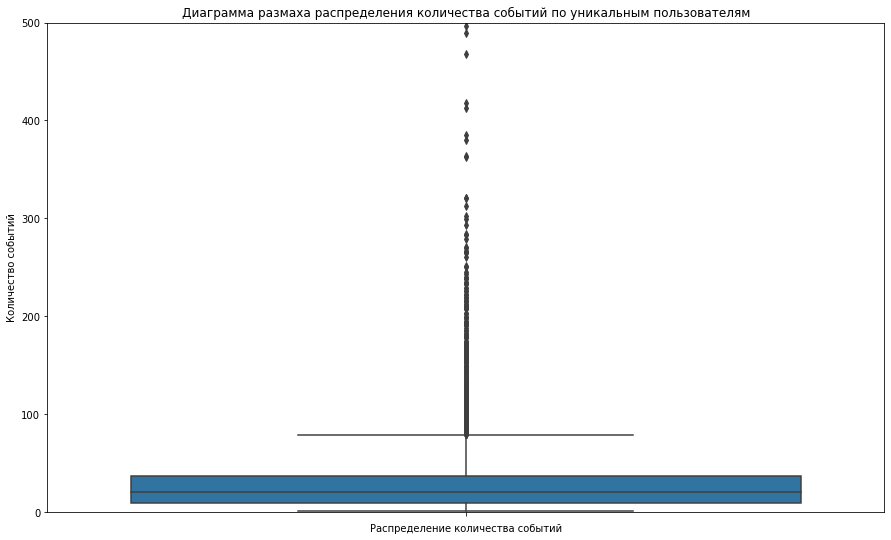

In [74]:
plt.figure(figsize=(15, 9))
ax = sns.boxplot(data=data, y="event_name")
ax.set(xlabel='Распределение количества событий', ylabel='Количество событий', title='Диаграмма размаха распределения количества событий по уникальным пользователям')
plt.ylim(0, 500)
plt.show()

In [75]:
df.groupby('user_id').agg({'event_name': 'count'}).mean()

event_name    32.275593
dtype: float64

Диаграмма размаха, а также описательная статистика показывают, что в распределение количества событий по уникальным пользователям есть выбросы, которые очень сильно влияют на среднее значение переменной, поэтому в данном случае лучше использовать медиану. Таким образом, в среднем на одного пользователя приходится 20 событий.

*Данными за какой период вы располагаете?*

In [76]:
df['date'].min()

datetime.date(2019, 7, 25)

In [77]:
df['date'].max()

datetime.date(2019, 8, 7)

Лог событий охватывает временной промежуток с 25 июля 2019 по 7 августа 2019 года. 

In [78]:
df_pivot = df.pivot_table(index='date', values='event_name', aggfunc='count')
df_pivot

,event_name
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


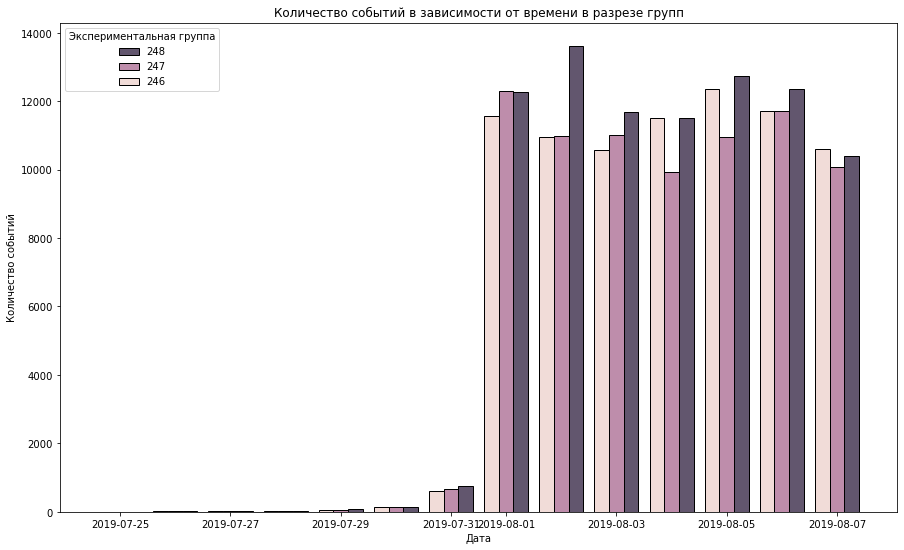

In [79]:
#строим диаграмму количества событий в зависимости от времени в разрезе групп
plt.figure(figsize=(15, 9))
sns.histplot(df, x='date', hue='group', multiple='dodge', shrink=.8, legend=False)
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend(title='Экспериментальная группа', loc='best', labels=['248', '247','246']);

Начиная с 1 августа 2019 видим значительное увеличение количества событий во всех группах, поэтому с этого дня данные можно считать полными, таким образом анализу подлежат данные за неделю с 1 по 7 августа 2019 года.

In [80]:
#отберем данные за выбранный период
df_filtered = df[df['date'] >= pd.to_datetime('2019-08-01')]

*Много ли событий и пользователей вы потеряли, отбросив старые данные?*

In [81]:
(df.shape[0] - df_filtered.shape[0]) / df.shape[0] * 100

1.159560630741897

In [82]:
(df['user_id'].nunique() - df_filtered['user_id'].nunique()) / df['user_id'].nunique() * 100

0.22513574361011784

В выбранный временной период не попало всего 1.16% событий и 0.23% уникальных пользователей.

*Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп*

In [83]:
ax = df_filtered.pivot_table(index='group', values='user_id', aggfunc='nunique')
ax

,user_id
group,
246,2484
247,2513
248,2537


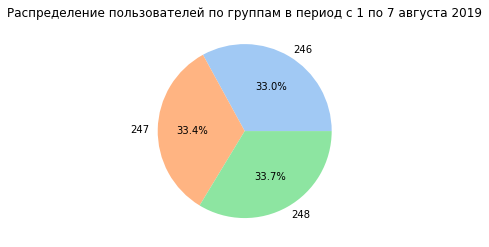

In [84]:
#строим круговую диаграмму распределения пользователей по группам
colors = sns.color_palette('pastel')[ 0:3 ]
plt.pie(ax['user_id'], labels=ax.index, colors=colors, autopct='%1.1f%%')
plt.title('Распределение пользователей по группам в период с 1 по 7 августа 2019');

Во всех трех группах есть пользователи. При этом количество пользователей в группах сравнимое.

**Вывод:**


В логе 5 уникальных событий и 7557 уникальных пользователей, при этом в среднем на одного пользователя приходится 32.28 события. Лог событий охватывает временной промежуток с 25 июля 2019 по 7 августа 2019 года, но до 1 августа 2019 событий значительно меньше, чем далее,  с этого дня данные можно считать полными, таким образом анализу подлежат данные за неделю с 1 по 7 августа 2019 года. Был создан новый датафрейм с временным срезом, в выбранный временной период не попало всего 1.16% событий и 0.23% уникальных пользователей, при этом во всех трех экспериментальных группах количество пользователей распределено сравнимо одинаково.

**Шаг 4. Изучите воронку событий**

*Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте*

In [85]:
event_freq = df_filtered['event_name'].value_counts().sort_values(ascending=False)
event_freq

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

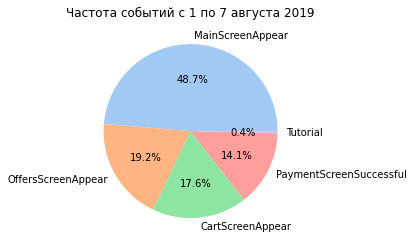

In [86]:
#круговая диаграмма частот событий
colors = sns.color_palette('pastel')[ 0:5 ]
plt.pie(event_freq, labels=event_freq.index, colors=colors, autopct='%1.1f%%')
plt.title('Частота событий с 1 по 7 августа 2019');

Самым частым событием является MainScreenAppear (почти половина всех событий), редким - Tutorial (менее 1 %).

*Посчитайте, сколько пользователей совершали каждое из этих событий*

In [87]:
event_user = df_filtered.groupby('event_name').agg({'user_id':'nunique'})
event_user.sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


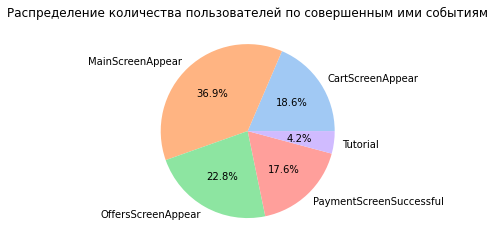

In [88]:
#круговая диаграмма распределения пользователей по событиям
colors = sns.color_palette('pastel')[ 0:5 ]
plt.pie(event_user['user_id'], labels=event_user.index, colors=colors, autopct='%1.1f%%')
plt.title('Распределение количества пользователей по совершенным ими событиям');

Также просмотр главной страницы приложения (MainScreenAppear) остается самым частым событием (что вполне логично), открытие (просмотр) руководства пользования приложением (Tutorial) остается самым редким событием.

In [89]:
#доля пользователей, которые хоть раз совершали событие
event_user['partial'] = round(event_user['user_id'] / df_filtered['user_id'].nunique() * 100, 2)

In [90]:
event_user['partial'].sort_values(ascending=False)

event_name
MainScreenAppear           98.47
OffersScreenAppear         60.96
CartScreenAppear           49.56
PaymentScreenSuccessful    46.97
Tutorial                   11.15
Name: partial, dtype: float64

Почти все пользователи посещали главную страницу приложения хотя бы один раз (недостающий процент пользователей можно объяснить срезом данных или, возможно, они переходили по ссылке уже товара непосредственно). 61% пользователей посещали окно товара, 50% - окно корзины, 47% - окно успешной оплаты, 11% - открытие (просмотр) руководства пользования приложением.

*Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки*

Можно предположить, что пользователь проходит следующую цепочку: 
1. Просмотр главной страницы приложения
2. Окно товара
3. Окно корзины
4. Окно успешной оплаты

В эту последовательную цепочку нельзя встроить просмотр руководства пользования приложением, так как это можно сделать в любой момент и это не влияет на покупку товара пользователем. Поэтому это событие не будем учитывать при расчёте воронки.

*По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B*

In [91]:
print('Отношение числа пользователей, посмотревших окно товара, к числу пользователей, открывших главное окно приложения:', 
      round(event_user.loc['OffersScreenAppear', 'user_id'] / event_user.loc['MainScreenAppear', 'user_id'] * 100, 2))

Отношение числа пользователей, посмотревших окно товара, к числу пользователей, открывших главное окно приложения: 61.91


In [92]:
print('Отношение числа пользователей, открывших страницу корзины, к числу пользователей, посмотревших окно товара:', 
      round(event_user.loc['CartScreenAppear', 'user_id'] / event_user.loc['OffersScreenAppear', 'user_id'] * 100, 2))

Отношение числа пользователей, открывших страницу корзины, к числу пользователей, посмотревших окно товара: 81.3


In [93]:
print('Отношение числа пользователей, просмотревших страницу успешной оплаты , к числу пользователей, открывших страницу корзины:', 
      round(event_user.loc['PaymentScreenSuccessful', 'user_id'] / event_user.loc['CartScreenAppear', 'user_id'] * 100, 2))

Отношение числа пользователей, просмотревших страницу успешной оплаты , к числу пользователей, открывших страницу корзины: 94.78


*На каком шаге теряете больше всего пользователей?*

Получается, что на первом шаге мы теряем больше всего пользователей: число пользователей, просмотревших страницу товара, к числу пользователей, просмотревших главное окно приложения (по сути, открывших приложение) - 62%. В то время, как 81.3% пользователей просмотревших товар, переходят на страницу корзину, и лишь 5.3% пользователей не оплачивают товар из корзины.

*Какая доля пользователей доходит от первого события до оплаты?*

In [94]:
all_stadies = len(set(df_filtered.loc[df_filtered['event_name'] == 'MainScreenAppear', 'user_id']) & \
set(df_filtered.loc[df_filtered['event_name'] == 'OffersScreenAppear', 'user_id']) & \
set(df_filtered.loc[df_filtered['event_name'] == 'CartScreenAppear', 'user_id']) & \
set(df_filtered.loc[df_filtered['event_name'] == 'PaymentScreenSuccessful', 'user_id']))
all_stadies

3429

In [95]:
round(all_stadies / df_filtered['user_id'].nunique() * 100, 2)

45.51

In [96]:
print('Отношение числа пользователей, купивших товар, к числу пользователей, открывших главное окно приложения:', 
      round(event_user.loc['PaymentScreenSuccessful', 'user_id'] / event_user.loc['MainScreenAppear', 'user_id'] * 100, 2))

Отношение числа пользователей, купивших товар, к числу пользователей, открывших главное окно приложения: 47.7


In [97]:
fig = go.Figure(go.Funnel(
    y = ["Посещение главной страницы приложения", "Посещение страницы товара", "Посещение корзины", "Страница успешной покупки"],
    x = [event_user.loc['MainScreenAppear', 'user_id'], event_user.loc['OffersScreenAppear', 'user_id'],
        event_user.loc['CartScreenAppear', 'user_id'], event_user.loc['PaymentScreenSuccessful', 'user_id']],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(title={'text' : 'Воронка событий', 'x':0.5, 'xanchor': 'center'        })
fig.show()

**Вывод:**

В логе всего 5 уникальных событий, самым частым из них является MainScreenAppear (почти половина всех событий), редким - Tutorial (менее 1 %). Среди уникальных пользователей просмотр главной страницы приложения (MainScreenAppear) также остается самым частым событием, открытие (просмотр) руководства пользования приложением (Tutorial) - самым редким событием. Почти все пользователи посещали главную страницу приложения хотя бы один раз (недостающий процент пользователей можно объяснить срезом данных или, возможно, они переходили по ссылке уже товара непосредственно). 61% пользователей посещали окно товара, 50% - окно корзины, 47% - окно успешной оплаты, 11% - открытие (просмотр) руководства пользования приложением.

Можно предположить, что пользователь проходит следующую цепочку:

1. Просмотр главной страницы приложения
2. Окно товара
3. Окно корзины
4. Окно успешной оплаты


В эту последовательную цепочку нельзя встроить просмотр руководства пользования приложением, так как это можно сделать в любой момент и это не влияет на покупку товара пользователем. Поэтому это событие не будем учитывать при расчёте воронки.
На первом шаге мы теряем больше всего пользователей: число пользователей, просмотревших страницу товара, к числу пользователей, просмотревших главное окно приложения (по сути, открывших приложение) - 62%. В то время, как 81.3% пользователей просмотревших товар, переходят на страницу корзину, и лишь 5.3% пользователей не оплачивают товар из корзины. 48% пользователей доходит от первого события к последнему. 

**Шаг 5. Изучите результаты эксперимента**

*Сколько пользователей в каждой экспериментальной группе?*

In [98]:
groups = df_filtered.pivot_table(index='group', values='user_id', aggfunc='nunique')
groups

,user_id
group,
246,2484
247,2513
248,2537


In [99]:
df_filtered['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

В экспериментальных группах примерно одинаковое количество пользователей и одинаковое число событий.

*Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247*

*Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?*

Воспользуемся критериями успешного A/A-теста: 
* Количество пользователей в различных группах различается не более, чем на 1%;
* Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
* Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
* Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [100]:
#создадим три датасета по группам
df_filtered_246 = df_filtered.query('group == 246')
df_filtered_247 = df_filtered.query('group == 247')
df_filtered_248 = df_filtered.query('group == 248')

In [101]:
(1 - df_filtered_246['user_id'].nunique() / df_filtered_247['user_id'].nunique()) * 100

1.1539992041384783

В контрольных группах количество пользователей различается на 1.15, при округлении до целых, получим необходимое различие в количестве пользователей в различных группах не более, чем на 1%.

In [102]:
print('Совпадений по уникальным пользователям между контрольными группами:', \
      len(set(df_filtered_246['user_id']) & set(df_filtered_247['user_id'])))

Совпадений по уникальным пользователям между контрольными группами: 0


In [103]:
top_246 = df_filtered_246['event_name'].value_counts()
top_246

MainScreenAppear           37676
OffersScreenAppear         14767
CartScreenAppear           14690
PaymentScreenSuccessful    11852
Tutorial                     317
Name: event_name, dtype: int64

In [104]:
top_247 = df_filtered_247['event_name'].value_counts()
top_247

MainScreenAppear           39090
OffersScreenAppear         15179
CartScreenAppear           12434
PaymentScreenSuccessful     9981
Tutorial                     338
Name: event_name, dtype: int64

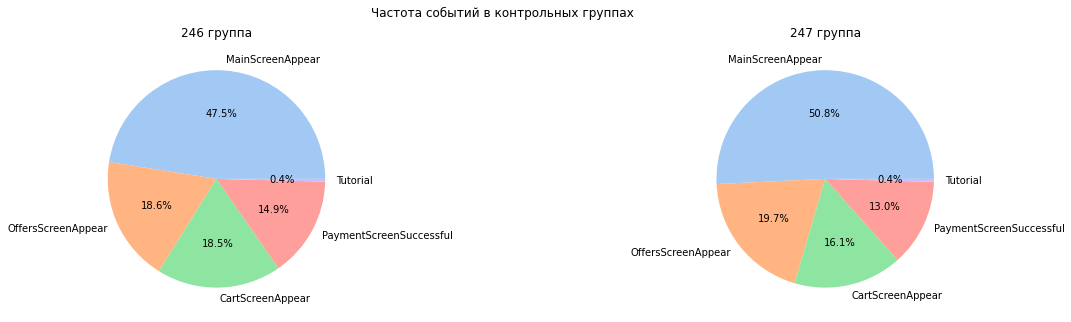

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Частота событий в контрольных группах')

ax1.pie(top_246, labels = list(top_246.index), colors=sns.color_palette('pastel'), autopct='%1.1f%%')
ax1.set_title('246 группа')

ax2.pie(top_247, labels = list(top_247.index), colors=sns.color_palette('pastel'), autopct='%1.1f%%')
ax2.set_title('247 группа');

Самым популярным событием в обеих контрольных группах является - просмотр главной страницы приложения (MainScreenAppear).

In [106]:
def st_parts(event_name, group1, group2, alpha):
    #alpha = 0.01

    #число уникальных пользователей, совершивших событие 
    n_group1_event = group1[group1['event_name'] == event_name]['user_id'].nunique() 
    n_group2_event = group2[group2['event_name'] == event_name]['user_id'].nunique()

    #число уникальных пользователей в группах
    n_group1 = group1['user_id'].nunique()
    n_group2 = group2['user_id'].nunique()


    p1 = n_group1_event / n_group1
    p2 = n_group2_event / n_group2

    p_combined = (n_group1_event + n_group2_event) / (n_group1 + n_group2)
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / n_group1 + 1 / n_group2)) 


    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница.\nРазница в долях: ', \
              round(abs(1-p1/p2)*100, 2), '%')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.\nРазница в долях: ', \
              round(abs(1-p1/p2)*100, 2), '%')




Проверим, имеются ли статистически значимые различия между пропорциями, наблюдаемыми на контрольных выборках.

**Нулевая гипотеза:** статистически значимых различий между долями нет.

**Альтернативная гипотеза:** статистически значимые различия  между долями есть.

In [107]:
#проверим, каждое доли событий в контрольных группах
for i in df_filtered_246['event_name'].unique():
    print(i)
    st_parts(i, df_filtered_246, df_filtered_247, 0.01)
    print()

Tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  0.62 %

MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  0.11 %

OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  2.63 %

PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  4.84 %

CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  3.46 %



Таким образом, различие в долях не имеет статистической значимости.  Разбиение на группы работает корректно.

*Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?*

Проверим, имеются ли статистически значимые различия между пропорциями, наблюдаемыми на экспериментальных выборках.

**Нулевая гипотеза:** статистически значимых различий между долями нет.

**Альтернативная гипотеза:** статистически значимые различия  между долями есть.

In [108]:
#сравниваем результаты 246 и 248 групп
print('246 и 248 группы')
for i in df_filtered_246['event_name'].unique():
    print(i)
    st_parts(i, df_filtered_246, df_filtered_248, 0.01)
    print()

246 и 248 группы
Tutorial
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  1.77 %

MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  0.37 %

OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  2.87 %

PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  3.78 %

CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  5.12 %



Статистически значимых различий в долях на выборках 246 и 248 нет.

In [109]:
#сравниваем результаты 247 и 248 групп
print('247 и 248 группы')
for i in df_filtered_246['event_name'].unique():
    print(i)
    st_parts(i, df_filtered_247, df_filtered_248, 0.01)
    print()

247 и 248 группы
Tutorial
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  2.4 %

MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  0.27 %

OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  0.23 %

PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  1.01 %

CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  1.61 %



Статистически значимых различий в долях на выборках 247 и 248 нет.

In [110]:
#объединим контрольные группы
c_group = pd.concat([df_filtered_247, df_filtered_246], axis=0)

In [111]:
#сравниваем результаты объединенной контрольной группы и 248 группы
print('объединенная контрольная группа и 248 группа\n')
for i in df_filtered_246['event_name'].unique():
    print(i)
    st_parts(i, c_group, df_filtered_248, 0.05)
    print()

объединенная контрольная группа и 248 группа

Tutorial
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  2.09 %

MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  0.32 %

OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  1.54 %

PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  1.37 %

CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Разница в долях:  3.36 %



Также статистически значимых различий в долях на объединенной контрольной выборке и 248 выборке нет.

*Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.*

При проверке статистических гипотез мной был выбран уровень значимости в 0.01. Было проведено 20 проверок статистических гипотез, следовало бы применить корректировку уровня значимости на множественное сравнение, но в данной ситуации этого нет смысла делать, так как были подтверждены нулевые гипотезы, а при поправке на множественное сравнение уровень значимости станет еще выше (то есть в числах альфа станет еще меньше, чем выбранный 0.01), а значит, полученное p-значение, которое было больше 0.01, будет больше и скорректированного значения.

**Вывод:**

Для эксперимента контрольные группы были выбраны корректно: в них нет одинаковых пользователей, они почти одинаковы по количеству пользователей и в долях этих групп нет статистических значимых различий на уровне 0.01. Сравнение каждой из контрольных групп и объединенной контрольной группы с экспериментальной группой также не выявило статистически значимых различий в долях между этими группами, а значит, изменение шрифта во всем приложении никак не повлияло на пользователей, т.е. если дизайнеры захотели просто поменять шрифт, то менеджерам не стоит бояться, пользователи отнеслись к этому лояльно. Если же преследовать цели повышения конверсия - изменение шрифта не привело к этому. Учитывая большой отток на первом шаге воронки: с главного экрана на страницу с товаром, надо менять что-то на главной странице приложения.

**Общий вывод**:

1. Для анализа данных был предоставлен набор, содержащий 244126 записей и 4 столбца. 
2. В предообработке таблицы данных были удалены явные дубликаты, изменены названия столбцов, добавлены столбец с датой, изменен тип данных у столбца с датой и временем события. Пропущенных значений в датафрейме нет. 
3. Всего в  логе 5 уникальных событий и 7557 уникальных пользователей, при этом в среднем на одного пользователя приходится 32.28 события. Лог событий охватывает временной промежуток с 25 июля 2019 по 7 августа 2019 года, но до 1 августа 2019 событий значительно меньше, чем далее, с этого дня данные можно считать полными, поэтому было принято решение создать новый датафрейм с временным срезом от 1 до 7 августа 2019 года, в выбранный временной период не попало всего 1.16% событий и 0.23% уникальных пользователей, при этом во всех трех экспериментальных группах количество пользователей распределено сравнимо одинаково.
4. Самым частым событием является MainScreenAppear (почти половина всех событий), редким - Tutorial (менее 1 %). Среди уникальных пользователей просмотр главной страницы приложения (MainScreenAppear) также остается самым частым событием, открытие (просмотр) руководства пользования приложением (Tutorial) - самым редким событием. Почти все пользователи посещали главную страницу приложения хотя бы один раз (недостающий процент пользователей можно объяснить срезом данных или, возможно, они переходили по ссылке уже товара непосредственно). 61% пользователей посещали окно товара, 50% - окно корзины, 47% - окно успешной оплаты, 11% - открытие (просмотр) руководства пользования приложением. Можно предположить, что пользователь проходит следующую цепочку: 
* Просмотр главной страницы приложения
* Окно товара
* Окно корзины
* Окно успешной оплаты
    
    В эту последовательную цепочку нельзя встроить просмотр руководства пользования приложением, так как это можно сделать в любой момент и это не влияет на покупку товара пользователем. Поэтому это событие не будем учитывать при расчёте воронки. На первом шаге мы теряем больше всего пользователей: число пользователей, просмотревших страницу товара, к числу пользователей, просмотревших главное окно приложения (по сути, открывших приложение) - 62%. В то время, как 81.3% пользователей просмотревших товар, переходят на страницу корзину, и лишь 5.3% пользователей не оплачивают товар из корзины. 48% пользователей доходит от первого события к последнему.
5. Для эксперимента контрольные группы были выбраны корректно: в них нет одинаковых пользователей, они почти одинаковы по количеству пользователей и в долях этих групп нет статистических значимых различий на уровне 0.01. Сравнение каждой из контрольных групп и объединенной контрольной группы с экспериментальной группой также не выявило статистически значимых различий в долях между этими группами, а значит, изменение шрифта во всем приложении никак не повлияло на пользователей, т.е. если дизайнеры захотели просто поменять шрифт, то менеджерам не стоит бояться, пользователи отнеслись к этому лояльно. Если же преследовать цели повышения конверсии - изменение шрифта не привело к этому. Учитывая большой отток на первом шаге воронки: с главного экрана на страницу с товаром, надо менять что-то на главной странице приложения.  
